# Analyzing the Performance of LSTM code using Profiler


Note the instructions where not clear on whether we are supposed to improve the performance or just analyse it. I went with just analyzing the performance using the tools mentioned. Not sure why we were asked to use nbocnvert ? Julia notebooks let me convert my code to .jl files directly

# 1) Read the performance tips 

Finished reading the performance tips - Key points that I didn't think of earlier

1. Copying isn't always bad 
2. Accessing arrays in memory order along columns

# 2) Check for type instabilities. I checked for type instabilities by running @code_warntype on one epoch of the training set

ANALYSIS : Based on the example in the Perfomance tips documents - None of the variables in the train function seem to have type instabilities
        . For example in the perfomance tips they have a variable y that was the Union{Int64, Float 64} which would be type instable. But based on this variable list for train function
#unused#::#kw##train
#temp#@_2::Array{Any,1} ::#train model::Array{Any,1} sequence::Array{Array{Int64,1},1} optim::Array{Knet.Adam,1} S::Int64
#temp#@_8::Int64
#temp#@_9::Int64
#temp#@_10::Any
#temp#@_11::Int64 pdrop::Any

I also verified the code_warntype for the gneerate function here is the summary

Variables:
  #self#::#generate
  model::Array{Any,1}
  tok2int::Dict{Char,Int64}
  nchar::Int64
  k::Char
  v::Int64
  #temp#@_7::Int64
  #temp#@_8::Int64
  t::Int64
  embed::Any
  #temp#@_11::Int64
  ypred::Any
  #temp#@_13::Int64
  int2tok::Array{Char,1}
  input::Any
  state::Array{Any,1}
  i::Int64
  index::Int64
  #temp#@_19::Int64

Find rest of the results for code_warntype - in the LSTM_code_warntype.txt. Conclusion : I didn't find any code instabilities that i needed to fix

# 3 ) Profiling the code

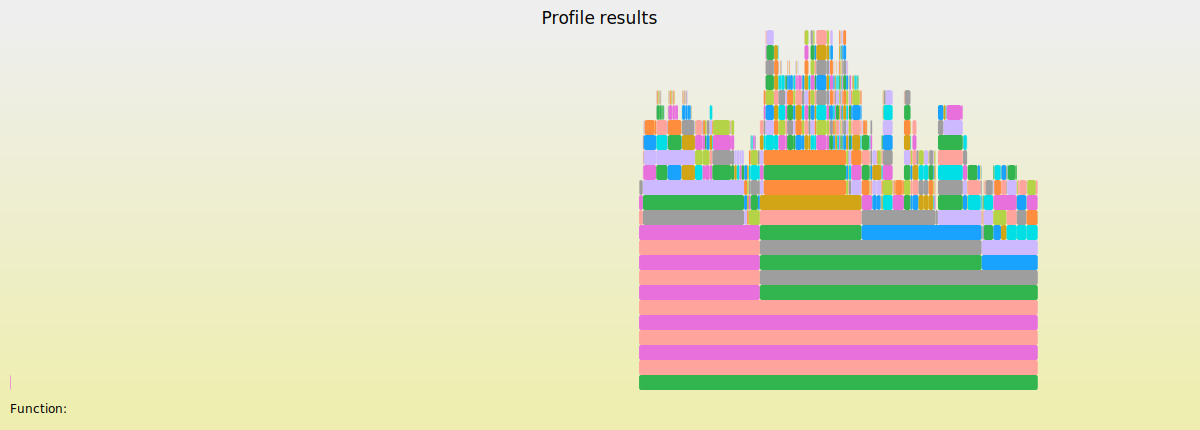

In [1]:
using ProfileView
f = open("cpu_profile.bin")
r = deserialize(f);
ProfileView.view(r[1], lidict=r[2])

Analysis

- The most problematic color - RED - mostly seems to arise from the unfuse.jl library. The next ones are backward_pass in core.jl.
- Based on the length of the strips - most of the time in my code seems to have been spent in the loss and predict sections of the training function = which definitely makes sense
- Each LSTM calculation seems right. Because most of my gate calculations shouldn't take that long anyway

# Memory Allocations:

1.  Using the memory allocations - We can see that most of the memory used is for the cell states/gates
2. The memory allocations are significantly smaller for GPU comapred to CPU
3. I am checking in the .mem files i generated using the --track-allocation flag


# CPU vs GPU

Here are some Epoch results from training on GPU on AWS :



# GPU Epoch Information

(:epoch, 0, :loss, 4.3178406f0)
  5.653050 seconds (2.62 M allocations: 114.479 MiB, 0.62% gc time)
  
  
(:epoch, 1, :loss, 6.149815f0)
  1.488483 seconds (1.30 M allocations: 47.919 MiB, 0.78% gc time)
  
  
(:epoch, 2, :loss, 16.04837f0)
  1.161822 seconds (1.21 M allocations: 45.191 MiB, 0.98% gc time)
  
(:epoch, 3, :loss, 17.054678f0)
  0.999926 seconds (1.17 M allocations: 43.193 MiB, 1.05% gc time)
  
(:epoch, 4, :loss, 15.71337f0)
  0.934595 seconds (1.18 M allocations: 41.958 MiB, 1.08% gc time)
  
(:epoch, 5, :loss, 14.648461f0)
  0.901453 seconds (1.20 M allocations: 42.107 MiB, 1.13% gc time)
(:epoch, 6, :loss, 13.888727f0)

  0.910199 seconds (1.22 M allocations: 42.244 MiB, 1.05% gc time)
(:epoch, 7, :loss, 12.295269f0)

  0.904278 seconds (1.24 M allocations: 42.083 MiB, 1.10% gc time)
(:epoch, 8, :loss, 10.94912f0)

  0.967196 seconds (1.20 M allocations: 41.275 MiB, 0.51% gc time)
(:epoch, 9, :loss, 9.442087f0)

  0.885926 seconds (1.25 M allocations: 41.912 MiB, 1.08% gc time)
(:epoch, 10, :loss, 8.839104f0)

# CPU Epoch Information
 29.420231 seconds (2.35 M allocations: 13.129 GiB, 5.28% gc time)
 
(:epoch, 1, :loss, 14.241066161676821)
 23.105251 seconds (1.82 M allocations: 10.573 GiB, 5.83% gc time)
 
(:epoch, 2, :loss, 21.454825487000928)
 23.270694 seconds (1.63 M allocations: 9.716 GiB, 7.35% gc time)
 
(:epoch, 3, :loss, 20.887890630111798)
 21.675195 seconds (1.56 M allocations: 9.288 GiB, 8.12% gc time)
 
(:epoch, 4, :loss, 19.00399380927323)
 26.018919 seconds (1.56 M allocations: 9.053 GiB, 22.51% gc time)
 
(:epoch, 5, :loss, 17.085640200316718)
 23.793098 seconds (1.56 M allocations: 8.861 GiB, 20.44% gc time)
 
(:epoch, 6, :loss, 15.786866912889108)
 26.935693 seconds (1.58 M allocations: 8.792 GiB, 25.99% gc time)
 
(:epoch, 7, :loss, 14.458334938174682)
 29.970075 seconds (1.58 M allocations: 8.689 GiB, 28.91% gc time)
 
(:epoch, 8, :loss, 12.190435362153428)
 35.590011 seconds (1.58 M allocations: 8.576 GiB, 34.49% gc time)
 
(:epoch, 9, :loss, 10.623822523189117)
 31.317649 seconds (1.58 M allocations: 8.540 GiB, 31.88% gc time)
 
(:epoch, 10, :loss, 10.004642300779901)
 26.177504 seconds (2.29 M allocations: 13.124 GiB, 7.77% gc time)

CONCLUSION : As you can clearly see - training on the GPU is faster and takes lesser allocations. GPU time is so FAST!